### Problem Statement
New buyers of residential properties are usually unfamiliar with the market prices. Depending on criterias such as locations, amenities, lot size and livable area, the price can varies greatly. As a data scientist, you would like to help buyers to determine the reasonable selling price for residential properties so that they are not over-paying for them and know when a property is a good deal.
Your tasks are:-
- Create a model to predict the sale price based on the features provided in the Ames Housing Dataset
- Identify the top 5 features which would greatly influence the price which the buyers should take note of

### Importing Libraries

In [429]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict

### Functions Definition

In [430]:
def boxplot_count_subplot(x, feature_list, data, row, col, figure_size=(20, 15)):
    # This function plots boxplot and count bar graph for each feature as as subplots
    # Declaring and initialising variables
    fig, ax = plt.subplots(figsize=figure_size, nrows=2, ncols = 3)
    i = 0
    
    # Loop through feature_list to create subplot for each feature
    for feature in feature_list:
        sns.boxplot(x=x, y=feature, data=data, ax=ax[0,i], order=data[feature].value_counts().index)
        sns.barplot(x=data[feature].value_counts(),y=data[feature].value_counts().index, ax=ax[1, i])
        i+=1

#----------------------------------------------------------------------------------------------        
        
def corr_plots(data, heatmap_size=(8, 8), heatmap_title_fontsize = 16, pair_title_fontsize = 16):
    # Heatmap
    plt.figure(figsize=heatmap_size)
    pearson_corr = data.corr()
    mask = np.zeros_like(pearson_corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(pearson_corr, annot=True, mask=mask, vmax = 1, vmin = -1)
    plt.title('Correlation Heatmap', fontweight = 'bold', fontsize=heatmap_title_fontsize)
    
    # Plot Pairplot
    pair = sns.pairplot(data)
    pair.fig.suptitle('Pairplot Between Features', fontweight = 'bold', fontsize=pair_title_fontsize)
    pair.fig.subplots_adjust(top=0.9)

#----------------------------------------------------------------------------------------------
    
def scatter_plot_3_features(data, x, y, features_list, rows, cols, 
                        figsize=(12,12), t_fontsize=10, t_dist_top = 0.9, marker_size=10):
    '''
    data: DataFrame of the data
    x: String. Numeric common feature to be set as x axis of all subplots
    y: String. Numeric common feature to be set as x axis of all subplots
    Features: List of strings to be set as hue in scatterplot
    rows: No of rows
    cols: No of cols
    figsize: tuple (Width, Height)
    '''
    fig, ax = plt.subplots(figsize=figsize, nrows=rows, ncols=cols)
    for i in range(len(features_list)):
        if rows > 1 and cols > 1:
            sns.scatterplot(x=x, y=y, data=data, hue=features_list[i], ax=ax[int(i/cols),i%cols], s=marker_size)
            ax[int(i/cols),i%cols].set_title(f"{y} vs {x} By {features_list[i]}")
        else:
            sns.scatterplot(x=x, y=y, data=data, hue=features_list[i], ax=ax[i], s=marker_size)
            ax[i].set_title(f"{y} vs {x} By {features_list[i]}")
    plt.suptitle(f"{y} vs {x} By Various Features", fontweight='bold', fontsize=t_fontsize)
    fig.subplots_adjust(top=t_dist_top)

#----------------------------------------------------------------------------------------------
    
def scatter_plot_by_labels(data, x, y, feature, rows, cols,
                          figsize=(12,12), t_fontsize=10, t_dist_top = 0.9, marker_size=10, ci=95):
    fig, ax = plt.subplots(figsize = figsize, nrows = rows, ncols = cols, sharex=True, sharey=True, squeeze=False)
    for i in range(data[feature].nunique()):
        sns.regplot(x=x, y=y, data=data[data[feature]==data[feature].unique()[i]],
                    ax=ax[int(i/cols),i%cols], ci=ci, line_kws={'color':'red'},
                    scatter_kws={'s':marker_size})
        ax[int(i/cols),i%cols].set_title(data[feature].unique()[i])
    fig.suptitle(f'{y} vs {x} by {feature}', fontsize=t_fontsize, fontweight="bold")
    fig.subplots_adjust(top=t_dist_top)

#----------------------------------------------------------------------------------------------

def prePost_logtransform(data, x, y, feature, label, figsize=(12,12), t_fontsize=10,
                         t_dist_top = 0.9):
    fig, ax = plt.subplots(figsize=figsize, nrows=1, ncols=2, sharey=True)
    # Comparison of scatter plot before and after transformation of x 
    # Plot for Sale Price vs Lot Area - Before Transformation for feature = label
    sns.regplot(x=x, y=y, data=data[data[feature]==label], ax=ax[0])
    ax[0].set_title('Sale Price vs Lot Area - Before Transformation')
    ax[0].set_xticks(ax[0].get_xticks())
    ax[0].set_xticklabels(ax[0].get_xticks(), rotation=90)

    # Plot for Sale Price vs Lot Area - After Transformation for Neighborhood = Edwards
    sns.regplot(x=np.log(data[data[feature]==label][x]), y=data[data[feature]==label][y], ax=ax[1])
    ax[1].set_title('Sale Price vs Lot Area - After Transformation')

    # Set Main Title
    fig.suptitle(f'Effect of Transformation on Lot Area for {feature}: {label}', fontsize = t_fontsize, fontweight='bold')
    fig.subplots_adjust(top=t_dist_top)
    
    # Correlation Values
    temp = data[data[feature]==label].copy()
    new_x = x + '_log'
    temp[new_x] = np.log(temp[x])
    pearson_corr = temp[[x, new_x, y]].corr()
    print(pearson_corr)

#----------------------------------------------------------------------------------------------

def imputing_lot_frontage(data):
    temp = data[data['Lot Area'] < 30000][['Lot Area', 'Lot Frontage']]
    temp.dropna(inplace=True)

    # Train Test Split Data Set
    x_train, x_test, y_train, y_test = train_test_split(temp[['Lot Area']], temp['Lot Frontage'], train_size = 0.8, random_state=60)

    # Instantiate OLS Model
    lr = LinearRegression()
    lr.fit(x_train, y_train)

    # Get index for missing Lot Frontage data for Lot Area < 30000
    missing_index = data[(data['Lot Area'] < 30000) & (data['Lot Frontage'].isnull())]['Lot Frontage'].index

    # Imputing data and save into Lot Frontage_Imputed
    data['Lot Frontage_Imputed'] = data['Lot Frontage']
    for i in missing_index:
        data.loc[i, 'Lot Frontage_Imputed'] = lr.predict([[data.loc[i, 'Lot Area']]])
        
    return data 
    
#----------------------------------------------------------------------------------------------
    
def clean(data):
    data=data.copy()
    # Converting MS SubClass, Overall Qual, Overall Cond to string as it is categorical data
    data['MS SubClass'] = data['MS SubClass'].astype('str')
    data['Overall Qual'] = data['Overall Qual'].astype('str')
    data['Overall Cond'] = data['Overall Qual'].astype('str')
    
    # Replace all 'NaN' from object columns
    for column in data.columns:
        if data[column].dtype == 'O':
            if column in ['Mas Vnr Type', 'Misc Feature']:
                data[column].replace(np.nan, 'None', inplace=True)
            else:
                data[column].replace(np.nan, 'n.a', inplace=True)
    
    # New Column for 'Garage Yr Blt and Impute missing 'Garage Yr Blt' rows with 'Year Built' data
    data['Garage Yr Blt_Imputed'] = data['Garage Yr Blt'].fillna(value=data['Year Built'])
    
    # Imputing Lot Frontage based on Linear Regression Model using Lot Area
    data = imputing_lot_frontage(data)
               
    # Set 0 for rows with house style as 1story but 2nd level SF is not 0
    data.loc[(data['House Style'] == '1Story') & (data['2nd Flr SF'] > 0), '2nd Flr SF'] = 0
    
    # Set 0 for rows with mas vnr type as None but Mas Vnr Area is not 0
    data.loc[data['Mas Vnr Type'] == 'None', 'Mas Vnr Area'] = 0
 
    return data

#----------------------------------------------------------------------------------------------

def prep(data):
    data=data.copy()
    # Engineering new numeric features
    data['Total SF'] = data['Total Bsmt SF'] + data['1st Flr SF'] + data['2nd Flr SF']
    data['Total SF**2'] = (data['Total Bsmt SF'] + data['1st Flr SF'] + data['2nd Flr SF'])**2
    data['No Of Bath'] = data['Bsmt Full Bath'] + (data['Bsmt Half Bath']/2) + data['Full Bath'] + (data['Half Bath']/2)
    data['Total Porch SF'] = data['Open Porch SF'] + data['Enclosed Porch'] + data['3Ssn Porch'] + data['Screen Porch']
    data['Amenities SF'] = data['Pool Area'] + data['Wood Deck SF'] + data['Garage Area']
    data['Age_Sold'] = data['Yr Sold'] - data['Year Built']
    data['Remod/Add Age_Sold'] = data['Yr Sold'] - data['Year Remod/Add']
    data['Gr Liv Area**2'] = data['Gr Liv Area']**2

    # Dropping Lot Frontage and Garage Yr Blt
    data.drop(columns = ['Lot Frontage', 'Garage Yr Blt'], inplace=True)
                                                         
    return data

#----------------------------------------------------------------------------------------------

def residual_plot(model, predictors, target, fig_title):
    plt.scatter(model.predict(predictors), target - model.predict(predictors))
    plt.axhline(y = 0, color='red')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residual (Target - Predicted)')
    plt.title(fig_title)

#----------------------------------------------------------------------------------------------

def output_result(model_type, features, Train_R2, Train_CV_R2, Test_R2, Train_RMSE, Train_CV_RMSE, Test_RMSE):
    results = pd.DataFrame([[model_type, str(features), Train_R2, Train_CV_R2, Test_R2, Train_RMSE, Train_CV_RMSE, Test_RMSE]])
    results.to_csv(r'..\datasets\results.csv', index=False, mode='a', header=False)

### Function Definitions Part 2 - Models

In [431]:
def pre_model_prep(data, model_features_list, train_size=0.8, random_state=60):
    # Assign required DataFrame data to variable X and y
    #X = prep(clean(data_ori[(data['1st Flr SF']<3500) & (data['Lot Area']<35000)]))
    X = data[model_features_list].copy()
    y = data['SalePrice'].copy()

    # One Hot Encoding X
    X_OHE = pd.get_dummies(data = X, drop_first=True)

    # Split Data in Train and Validation
    X_train, X_val, y_train, y_val = train_test_split(X_OHE, y, train_size=train_size, random_state = random_state)

    # Apply Standard Scaler on X_train and X_test
    ss = StandardScaler()
    X_train_scaled = ss.fit_transform(X_train)
    X_val_scaled = ss.transform(X_val)
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns)
    
    return X_train_scaled, X_val_scaled, y_train, y_val



def ols_model_result(X_train, y_train, X_val, y_val, cv=5):
    # Instantiate lr as LinearRegression
    lr = LinearRegression()

    # Fit using OLS
    lr.fit(X_train_scaled, y_train)

    # Assign cv
    cv_value = 5

    # R2 Score
    print('Using R2:-')
    # Training Set Using OLS
    print('Train R2 Score (OLS): ', lr.score(X_train_scaled, y_train))

    # Training Set Using Cross-Validation
    print('Train R2 Score (OLS with CV): ', 
          cross_val_score(lr, X_train_scaled, y_train, cv = cv_value).mean())

    # Validation Set Using OLS
    print('Validation R2 Score: ', lr.score(X_val_scaled, y_val))


    # Using RMSE
    print('\nUsing RMSE:-')
    # Training Set Using OLS
    print('Train RMSE Score (OLS): ', metrics.mean_squared_error(y_train, lr.predict(X_train_scaled))**0.5)

    # Training Set Using Cross-Validation
    print('Train RMSE Score (OLS with CV): ', 
          abs(cross_val_score(lr, X_train_scaled, y_train, cv = cv_value, scoring='neg_root_mean_squared_error').mean()))

    # Validation Set Using OLS
    print('Validation RMSE Score (OLS): ', metrics.mean_squared_error(y_val, lr.predict(X_val_scaled))**0.5)

    # Plot Residual Plot
    residual_plot(model = lr, predictors = X_val_scaled, target = y_val,
                  fig_title='OLS Regression Residual Plot')
    plt.title('Residual vs Predicted Values', fontweight='bold')
    
    # Output results to file
    '''output_result('OLS',
                  model_features_list,
                  lr.score(X_train_scaled, y_train),
                  cross_val_score(lr, X_train_scaled, y_train, cv = cv_value).mean(),
                  lr.score(X_val_scaled, y_val),
                  metrics.mean_squared_error(y_train, lr.predict(X_train_scaled))**0.5,
                  abs(cross_val_score(lr, X_train_scaled, y_train, cv = cv_value, scoring='neg_root_mean_squared_error').mean()),
                  metrics.mean_squared_error(y_val, lr.predict(X_val_scaled))**0.5
                 )
    '''
    
    # Plot coefficients bar graph
    no_of_features = X_train.shape[1]
    height = 2 + 0.5*no_of_features
    coefficients_df = pd.DataFrame(zip(X_train.columns, lr.coef_), columns=['features', 'coeff'])
    coefficients_df.sort_values(by='coeff', ascending=False, inplace=True)
    coefficients_df['abs_coeff'] = np.abs(coefficients_df['coeff'])
    fig, ax = plt.subplots(figsize=(15,height), nrows=1, ncols=2)
    fig.tight_layout(pad=15.0)
    sns.barplot(x=coefficients_df['coeff'], y=coefficients_df['features'], ax=ax[0])
    ax[0].set_title('Features Coefficients - Descending', fontweight='bold', fontsize=15)
    coefficients_df.sort_values(by='abs_coeff', ascending=False, inplace=True)
    sns.barplot(x=coefficients_df['abs_coeff'], y=coefficients_df['features'], ax=ax[1])
    ax[1].set_title('Features Abs Coefficients - Descending', fontweight='bold', fontsize=15)
    
    return lr

#----------------------------------------------------------------------------------------------

def ridge_model_result(X_train, y_train, X_val, y_val, cv=5, logspace_start=0, logspace_stop=2, num=1000):
    # Creating a array of alphas to be tested
    r_alphas=np.logspace(logspace_start, logspace_stop, num)
    
    # Assign cv
    cv_value = cv

    # Instantiate ridge_cv as RidgeCV
    ridge_cv=RidgeCV(alphas=r_alphas, cv=cv_value)

    # Fit Using RidgeCV
    ridge_cv.fit(X_train_scaled, y_train)

    # Print the best alpha
    print(f'Best alpha is {ridge_cv.alpha_}')

    # Instantiate ridge_model as Ridge using best alpha from ridge_cv
    ridge_model = Ridge(alpha=ridge_cv.alpha_)

    # Fit using Ridge
    ridge_model.fit(X_train_scaled, y_train)

    # R2 Score
    print('\nUsing R2:-')
    # Training Set Using Ridge
    print('Train R2 Score (Ridge): ', ridge_model.score(X_train_scaled, y_train))

    # Training Set Using Cross-Validation
    print('Train R2 Score (Ridge with CV): ', 
          cross_val_score(ridge_model, X_train_scaled, y_train, cv = cv_value).mean())

    # Validation Set Using Ridge
    print('Validation R2 Score: ', ridge_model.score(X_val_scaled, y_val))


    # Using RMSE
    print('\nUsing RMSE:-')
    # Training Set Using Ridge
    print('Train RMSE Score (Ridge): ', metrics.mean_squared_error(y_train, ridge_model.predict(X_train_scaled))**0.5)

    # Training Set Using Cross-Validation
    print('Train RMSE Score (Ridge with CV): ', 
          abs(cross_val_score(ridge_model, X_train_scaled, y_train, cv = cv_value, scoring='neg_root_mean_squared_error').mean()))

    # Validation Set Using Ridge
    print('Validation RMSE Score (Ridge): ', metrics.mean_squared_error(y_val, ridge_model.predict(X_val_scaled))**0.5)

    # Plot Residual Plot
    residual_plot(model = ridge_model, predictors = X_val_scaled, target = y_val,
                  fig_title='Ridge Regression Residual Plot')
    
    # Output results to file
    '''output_result('Ridge', 
                  model_features_list,
                  ridge_model.score(X_train_scaled, y_train),
                  cross_val_score(ridge_model, X_train_scaled, y_train, cv = cv_value).mean(),
                  ridge_model.score(X_val_scaled, y_val),
                  metrics.mean_squared_error(y_train, ridge_model.predict(X_train_scaled))**0.5,
                  abs(cross_val_score(ridge_model, X_train_scaled, y_train, cv = cv_value, scoring='neg_root_mean_squared_error').mean()),
                  metrics.mean_squared_error(y_val, ridge_model.predict(X_val_scaled))**0.5
                 )
    '''
    
    # Plot coefficients bar graph
    no_of_features = X_train.shape[1]
    height = 2 + 0.5*no_of_features
    coefficients_df = pd.DataFrame(zip(X_train.columns, ridge_model.coef_), columns=['features', 'coeff'])
    coefficients_df.sort_values(by='coeff', ascending=False, inplace=True)
    coefficients_df['abs_coeff'] = np.abs(coefficients_df['coeff'])
    fig, ax = plt.subplots(figsize=(15,height), nrows=1, ncols=2)
    fig.tight_layout(pad=15.0)
    sns.barplot(x=coefficients_df['coeff'], y=coefficients_df['features'], ax=ax[0])
    ax[0].set_title('Features Coefficients - Descending', fontweight='bold', fontsize=15)
    coefficients_df.sort_values(by='abs_coeff', ascending=False, inplace=True)
    sns.barplot(x=coefficients_df['abs_coeff'], y=coefficients_df['features'], ax=ax[1])
    ax[1].set_title('Features Abs Coefficients - Descending', fontweight='bold', fontsize=15)
    
    return ridge_model

#----------------------------------------------------------------------------------------------

def lasso_model_result(X_train, y_train, X_val, y_val, cv=5, logspace_start=-5, logspace_stop=5, num=1000):
    # Creating a array of alphas to be tested
    l_alphas = np.logspace(logspace_start, logspace_stop, num)

    #Instantiate lasso_cv as LassoCV
    lasso_cv = LassoCV(alphas = l_alphas, cv=5, max_iter=50000)

    # Fit using LassoCV
    lasso_cv.fit(X_train_scaled, y_train)

    # Print the best alpha
    print(f'Best alpha is {lasso_cv.alpha_}')

    # Instantiate lasso_model as Lasso using best alpha from lasso_cv
    lasso_model = Lasso(alpha=lasso_cv.alpha_, max_iter = 50000)

    # Fit using Lasso
    lasso_model.fit(X_train_scaled, y_train)

    # Assign cv
    cv_value = 5


    # R2 Score
    print('\nUsing R2:-')
    # Training Set Using Lasso
    print('Train R2 Score (Lasso): ', lasso_model.score(X_train_scaled, y_train))

    # Training Set Using Cross-Validation
    print('Train R2 Score (Lasso with CV): ', 
          cross_val_score(lasso_model, X_train_scaled, y_train, cv = cv_value).mean())

    # Validation Set Using Lasso
    print('Validation R2 Score: ', lasso_model.score(X_val_scaled, y_val))


    # Using RMSE
    print('\nUsing RMSE:-')
    # Training Set Using Lasso
    print('Train RMSE Score (Lasso): ', metrics.mean_squared_error(y_train, lasso_model.predict(X_train_scaled))**0.5)

    # Training Set Using Cross-Validation
    print('Train RMSE Score (Lasso with CV): ', 
          abs(cross_val_score(lasso_model, X_train_scaled, y_train, cv = cv_value, scoring='neg_root_mean_squared_error').mean()))

    # Validation Set Using Lasso
    print('Validation RMSE Score (Lasso): ', metrics.mean_squared_error(y_val, lasso_model.predict(X_val_scaled))**0.5)

    # Plot Residual Plot
    residual_plot(model = lasso_model, predictors = X_val_scaled, target = y_val,
                  fig_title='Lasso Regression Residual Plot')
    
    # Output results to file
    '''output_result('Lasso',
                  model_features_list,
                  lasso_model.score(X_train_scaled, y_train),
                  cross_val_score(lasso_model, X_train_scaled, y_train, cv = cv_value).mean(),
                  lasso_model.score(X_val_scaled, y_val),
                  metrics.mean_squared_error(y_train, lasso_model.predict(X_train_scaled))**0.5,
                  abs(cross_val_score(lasso_model, X_train_scaled, y_train, cv = cv_value, scoring='neg_root_mean_squared_error').mean()),
                  metrics.mean_squared_error(y_val, lasso_model.predict(X_val_scaled))**0.5
                 )
     '''
     
    # Plot coefficients bar graph
    no_of_features = X_train.shape[1]
    height = 2 + 0.5*no_of_features
    coefficients_df = pd.DataFrame(zip(X_train.columns, lasso_model.coef_), columns=['features', 'coeff'])
    coefficients_df.sort_values(by='coeff', ascending=False, inplace=True)
    coefficients_df['abs_coeff'] = np.abs(coefficients_df['coeff'])
    fig, ax = plt.subplots(figsize=(15,height), nrows=1, ncols=2)
    fig.tight_layout(pad=15.0)
    sns.barplot(x=coefficients_df['coeff'], y=coefficients_df['features'], ax=ax[0])
    ax[0].set_title('Features Coefficients - Descending', fontweight='bold', fontsize=15)
    coefficients_df.sort_values(by='abs_coeff', ascending=False, inplace=True)
    sns.barplot(x=coefficients_df['abs_coeff'], y=coefficients_df['features'], ax=ax[1])
    ax[1].set_title('Features Abs Coefficients - Descending', fontweight='bold', fontsize=15)
    
    return lasso_model

### Import Data and Clean Data

#### Read Data

In [432]:
# Read, clean, drop columns and dropna rows for train.csv
null_values = ['','#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND', 
               '1.#QNAN', '<NA>', 'N/A', 'NULL', 'NaN', 'n/a', 'nan', 'null']
data_ori = pd.read_csv('../datasets/train.csv', keep_default_na=False, na_values=null_values)
data = prep(clean(data_ori))

# Drop na rows
data.dropna(inplace=True)

### Modeling

To determine if the new models are performing well, we will be be using R2 and RMSE for evaluation. While both scores tell us the performance of our model, R2 score helps to compare our model with the null model. If R2 > 0, it is better than null model and vice versa.

To start the modeling, all the usable numeric features identified in the EDA were used in the models.

In [433]:
# Features selected from 02_EDA
usable_model_features_list = ['Age_Sold', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Total SF',
                               'Lot Area', 'Mas Vnr Area', 'Gr Liv Area', 'Overall Qual', 'Full Bath',
                               'No Of Bath', 'TotRms AbvGrd', 'Garage Area', 'Amenities SF', 'Fireplaces',
                               'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Total Porch SF',
                               'MS SubClass', 'MS Zoning', 'Land Contour', 'Neighborhood', 'Condition 1',
                              'Condition 2', 'House Style', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
                               'Exter Qual', 'Bsmt Qual', 'Bsmt Exposure', 'Heating QC', 'Central Air', 'Electrical',
                               'Kitchen Qual', 'Fireplace Qu', 'Garage Type', 'Garage Finish']

In [434]:
# Get all numeric features
model_features_list = [feature for feature in usable_model_features_list if data[feature].dtypes != 'O']

#### Prepare train and validation data

In [435]:
X_train_scaled, X_val_scaled, y_train, y_val = pre_model_prep(data, model_features_list, train_size=0.8, random_state=60)

#### OLS Model

Using R2:-
Train R2 Score (OLS):  0.7455623888172314
Train R2 Score (OLS with CV):  0.717731544716125
Validation R2 Score:  0.7881529564495084

Using RMSE:-
Train RMSE Score (OLS):  40118.47871754759
Train RMSE Score (OLS with CV):  41737.835500313304
Validation RMSE Score (OLS):  36008.33006470241


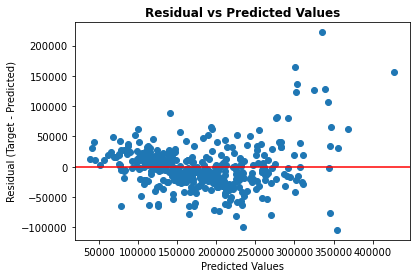

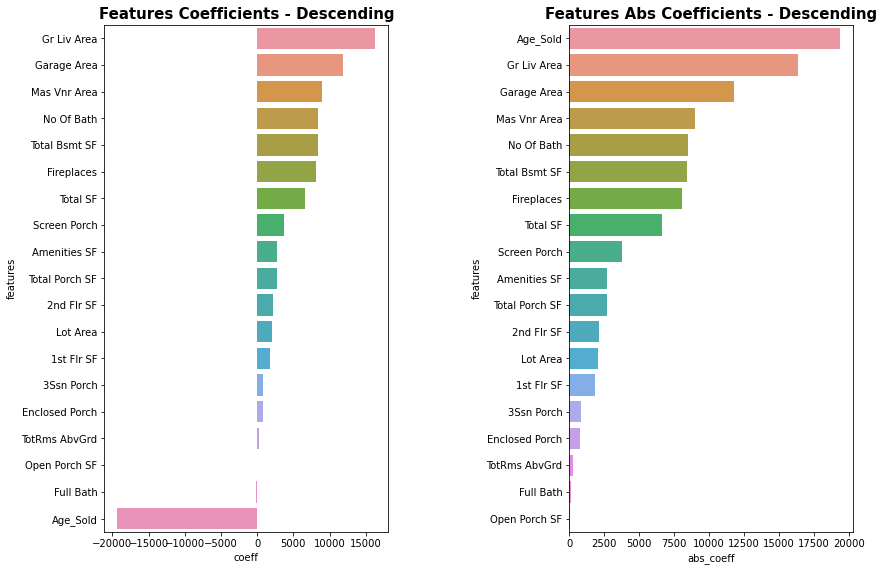

In [436]:
lr = ols_model_result(X_train_scaled, y_train, X_val_scaled, y_val)

- The OLS model R2 score and RMSE of training set is decent and it improved when the model is used on the validation data set
- The top few features are mainly features with SF.

#### Ridge Regression Model

Best alpha is 100.0

Using R2:-
Train R2 Score (Ridge):  0.7449915404412394
Train R2 Score (Ridge with CV):  0.7216472903791414
Validation R2 Score:  0.787997151725281

Using RMSE:-
Train RMSE Score (Ridge):  40163.457793937196
Train RMSE Score (Ridge with CV):  41436.627213249216
Validation RMSE Score (Ridge):  36021.56894850001


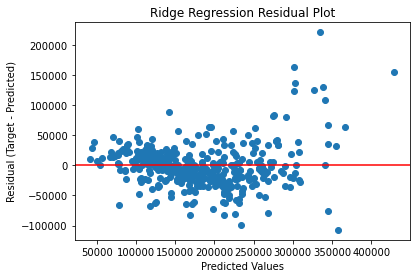

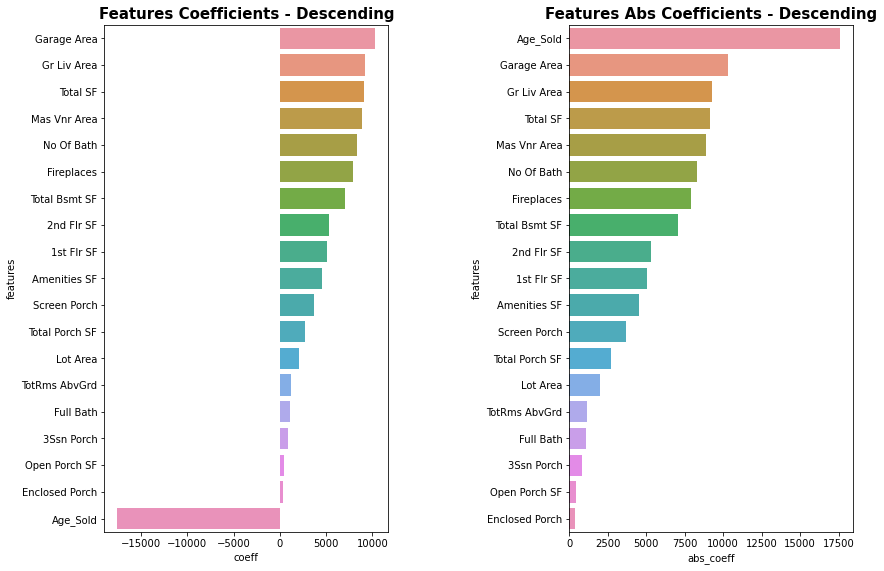

In [437]:
ridge_model = ridge_model_result(X_train_scaled, y_train, X_val_scaled, y_val, cv=5)

- The R2 score and RMSE of training set is decent and it improved when the model is used on the validation data set like with the OLS model.
- The top few features are Age_Sold, Mas Vnr Area, Total SF, Garage Area, Gr Liv Area
- Observed certain colinear features (e.g. 1st Flr SF, 2nd Flr SF) getting decent high coefficients

#### Lasso Regression Model

Best alpha is 1042.3606739764032

Using R2:-
Train R2 Score (Lasso):  0.7447280329391985
Train R2 Score (Lasso with CV):  0.7229937648548016
Validation R2 Score:  0.7894180744078839

Using RMSE:-
Train RMSE Score (Lasso):  40184.20345829977
Train RMSE Score (Lasso with CV):  41352.55747880448
Validation RMSE Score (Lasso):  35900.65095898544


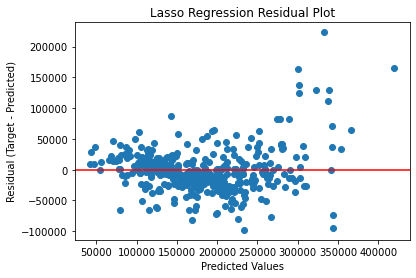

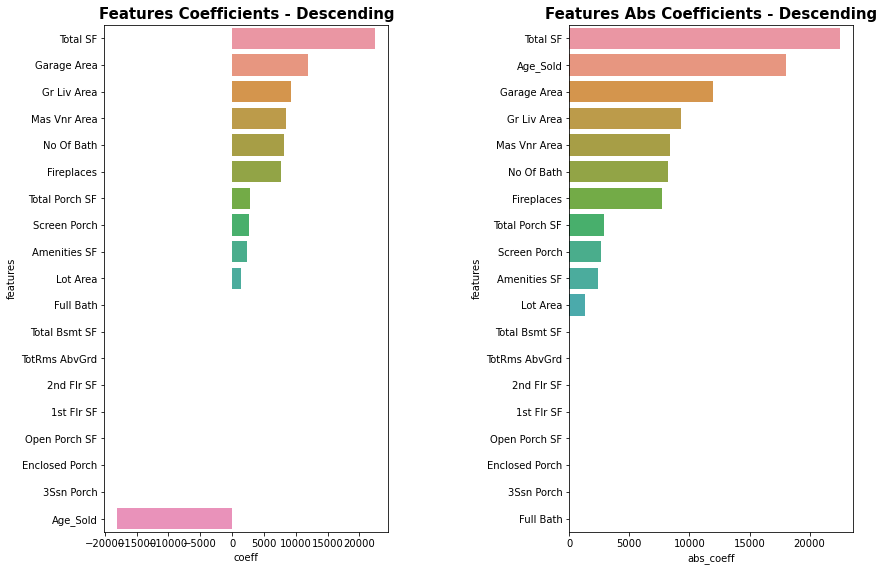

In [438]:
lasso_model = lasso_model_result(X_train_scaled, y_train, X_val_scaled, y_val, cv=5)

- The R2 score and RMSE of training set is decent and it improved when the model is used on the validation data set like with the OLS model.
- The top few features are Total SF, Age_Sold, Mas Vnr Area, Garage Area, Gr Liv Area which are similar to the ridge model
- Features that was used to create engineered features has ~0 coefficients
    - Full Bath, Total Bsmt SF, 2nd Flr SF, 1st Flr SF, Open Porch SF, Enclosed Porch, 3Ssn Porch

### Replacing Numeric Features with Engineered Features

By removing some of the features which were used to engineered features did not result in significantly worse scores for all 3 models.

#### Prepare train and validation data

In [439]:
# Define Numeric features to use
model_features_list = [feature for feature in usable_model_features_list if data[feature].dtypes != 'O']
drop_features = ['Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Open Porch SF',
 'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Full Bath', 'Amenities SF']
for feature in drop_features:
    model_features_list.remove(feature)

In [440]:
model_features_list

['Age_Sold',
 'Total SF',
 'Lot Area',
 'Mas Vnr Area',
 'Gr Liv Area',
 'No Of Bath',
 'TotRms AbvGrd',
 'Garage Area',
 'Fireplaces',
 'Total Porch SF']

In [441]:
X_train_scaled, X_val_scaled, y_train, y_val = pre_model_prep(data, model_features_list, train_size=0.8, random_state=60)

#### OLS Model

Using R2:-
Train R2 Score (OLS):  0.7439617749613832
Train R2 Score (OLS with CV):  0.7221193973523545
Validation R2 Score:  0.7888780641449529

Using RMSE:-
Train RMSE Score (OLS):  40244.46936708893
Train RMSE Score (OLS with CV):  41410.49723166101
Validation RMSE Score (OLS):  35946.65278732901


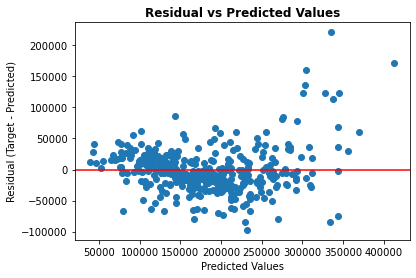

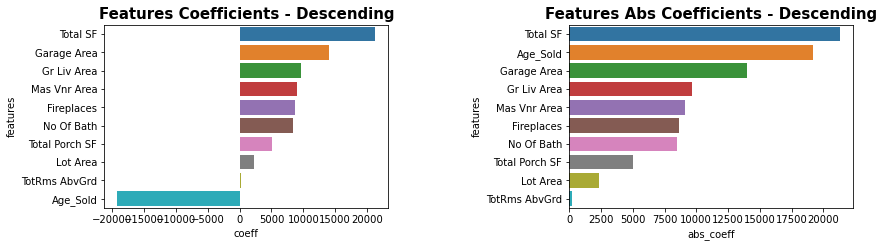

In [442]:
lr = ols_model_result(X_train_scaled, y_train, X_val_scaled, y_val)

#### Ridge Model

Best alpha is 100.0

Using R2:-
Train R2 Score (Ridge):  0.7435019528224678
Train R2 Score (Ridge with CV):  0.7257170424945343
Validation R2 Score:  0.7851495138674868

Using RMSE:-
Train RMSE Score (Ridge):  40280.59092073853
Train RMSE Score (Ridge with CV):  41191.98804772242
Validation RMSE Score (Ridge):  36262.68416229532


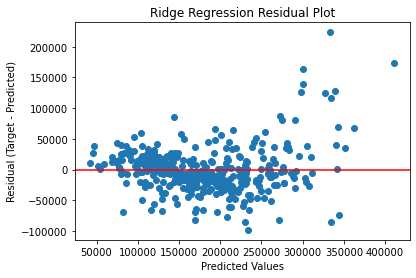

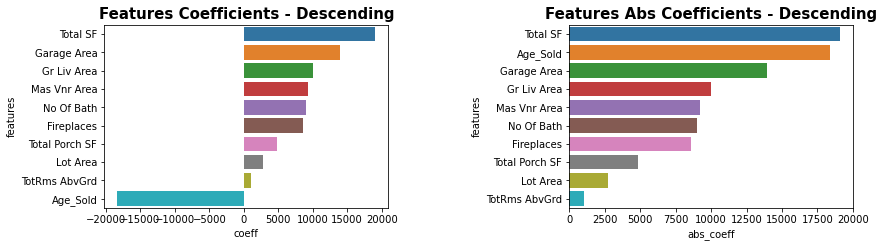

In [443]:
ridge_model = ridge_model_result(X_train_scaled, y_train, X_val_scaled, y_val, cv=5)

#### Lasso Model

Best alpha is 720.8715033782136

Using R2:-
Train R2 Score (Lasso):  0.7436865115978526
Train R2 Score (Lasso with CV):  0.7242858813698825
Validation R2 Score:  0.7892334801795453

Using RMSE:-
Train RMSE Score (Lasso):  40266.096708459634
Train RMSE Score (Lasso with CV):  41261.61631563828
Validation RMSE Score (Lasso):  35916.382606595704


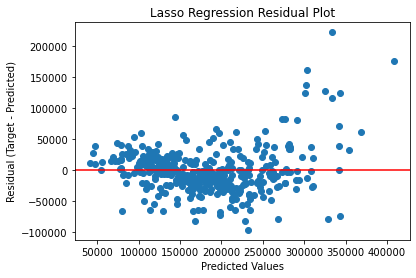

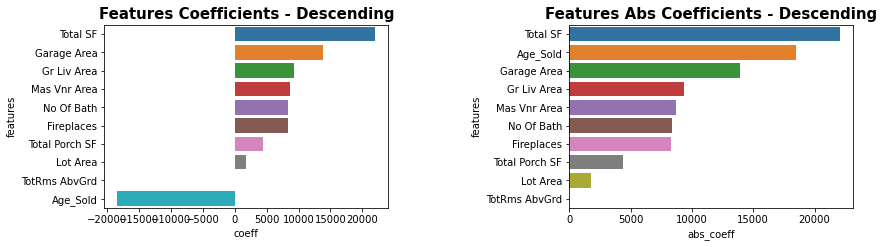

In [444]:
lasso_model = lasso_model_result(X_train_scaled, y_train, X_val_scaled, y_val, cv=5)

### Adding Categorical Features

For categorical features, we will be adding each feature one at a time to the model. Each model would be re-evaluated based on the R2 score and RMSE. If the R2 score drops/error increses, the last added feature would be dropped in subsequent models. The flowchart for the process is as shown:-

<img src="../imgs/feature_selection_flowchart.png">

#### Adding Overall Qual

In [445]:
# Previous Run list + Overall Qual
model_features_list = []
drop_features = ['Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Open Porch SF', 'Enclosed Porch', 
                 '3Ssn Porch', 'Screen Porch', 'Full Bath', 'MS SubClass', 'MS Zoning', 
                 'Land Contour', 'Neighborhood', 'Condition 1', 'Condition 2', 'House Style',
                 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Exter Qual', 'Bsmt Qual', 
                 'Bsmt Exposure', 'Heating QC', 'Central Air', 'Electrical', 'Kitchen Qual',
                  'Garage Type', 'Garage Finish', 'Fireplace Qu', 'Amenities SF']

for feature in usable_model_features_list:
    if feature not in drop_features:
        model_features_list.append(feature)

In [446]:
X_train_scaled, X_val_scaled, y_train, y_val = pre_model_prep(data, model_features_list, train_size=0.8, random_state=60)

#### OLS Model

Using R2:-
Train R2 Score (OLS):  0.8323348443053149
Train R2 Score (OLS with CV):  0.8081176895891705
Validation R2 Score:  0.8799445248472799

Using RMSE:-
Train RMSE Score (OLS):  32566.809207491515
Train RMSE Score (OLS with CV):  34214.18127838914
Validation RMSE Score (OLS):  27107.081562848514


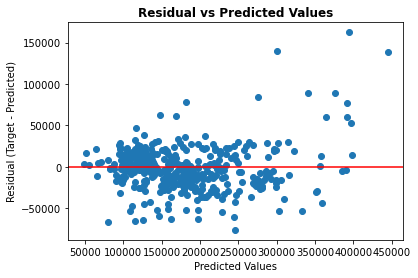

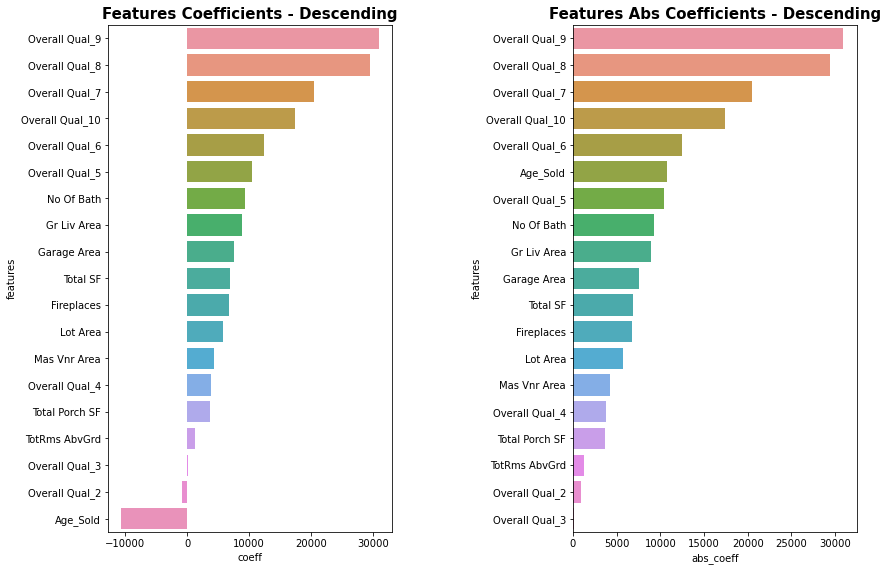

In [447]:
lr = ols_model_result(X_train_scaled, y_train, X_val_scaled, y_val)

#### Ridge Model

Best alpha is 100.0

Using R2:-
Train R2 Score (Ridge):  0.8312321632270869
Train R2 Score (Ridge with CV):  0.809082435871467
Validation R2 Score:  0.8726397456408481

Using RMSE:-
Train RMSE Score (Ridge):  32673.72454712488
Train RMSE Score (Ridge with CV):  34152.227447313446
Validation RMSE Score (Ridge):  27919.570686382314


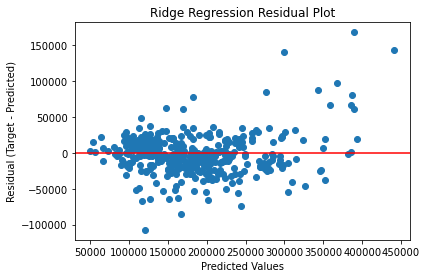

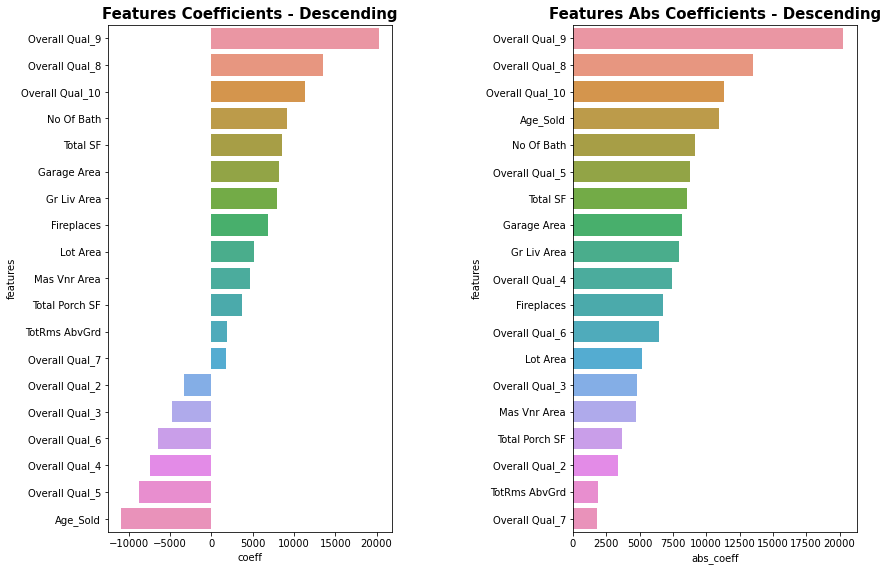

In [448]:
ridge_model = ridge_model_result(X_train_scaled, y_train, X_val_scaled, y_val, cv=5)

#### Lasso Model

Best alpha is 1e-05

Using R2:-
Train R2 Score (Lasso):  0.8323348443053149
Train R2 Score (Lasso with CV):  0.8081176895311675
Validation R2 Score:  0.8799445232333541

Using RMSE:-
Train RMSE Score (Lasso):  32566.809207491522
Train RMSE Score (Lasso with CV):  34214.181282812446
Validation RMSE Score (Lasso):  27107.081745051015


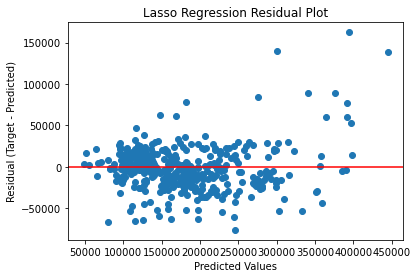

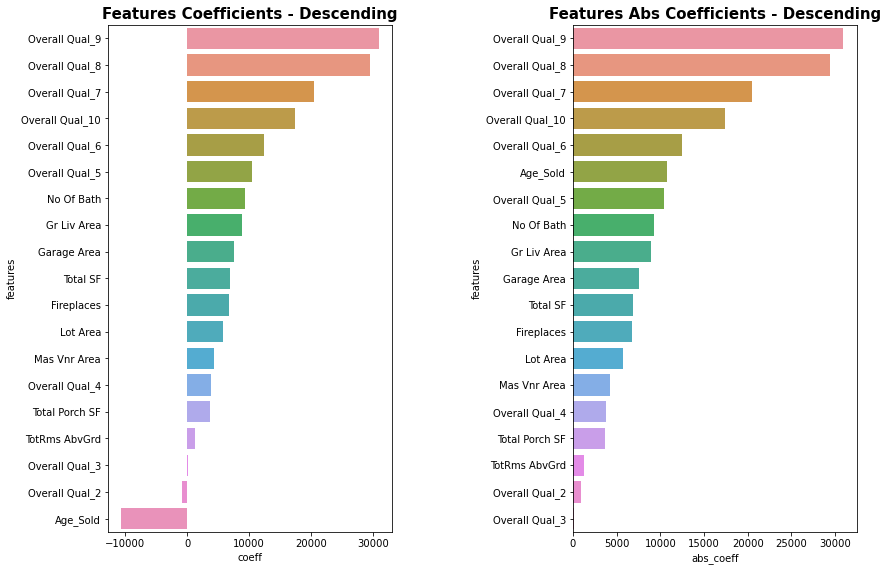

In [449]:
lasso_model = lasso_model_result(X_train_scaled, y_train, X_val_scaled, y_val, cv=5)

#### Adding MS Class.

In [450]:
# Previous Run list + MS Class
model_features_list = []
drop_features = ['Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Open Porch SF', 'Enclosed Porch', 
                 '3Ssn Porch', 'Screen Porch', 'Full Bath', 'MS Zoning', 
                 'Land Contour', 'Neighborhood', 'Condition 1', 'Condition 2', 'House Style',
                 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Exter Qual', 'Bsmt Qual', 
                 'Bsmt Exposure', 'Heating QC', 'Central Air', 'Electrical', 'Kitchen Qual',
                  'Garage Type', 'Garage Finish', 'Fireplaces', 'Fireplace Qu', 'Amenities SF']

for feature in usable_model_features_list:
    if feature not in drop_features:
        model_features_list.append(feature)

In [451]:
X_train_scaled, X_val_scaled, y_train, y_val = pre_model_prep(data, model_features_list, train_size=0.8, random_state=60)

Using R2:-
Train R2 Score (OLS):  0.8398989088734683
Train R2 Score (OLS with CV):  0.8113789844479872
Validation R2 Score:  0.8833152815936717

Using RMSE:-
Train RMSE Score (OLS):  31823.720203610996
Train RMSE Score (OLS with CV):  33962.62463183933
Validation RMSE Score (OLS):  26723.83417920751


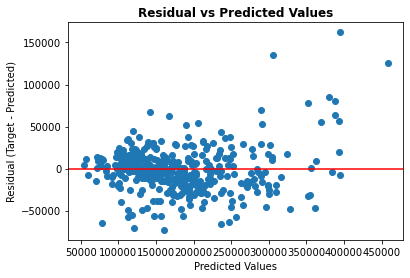

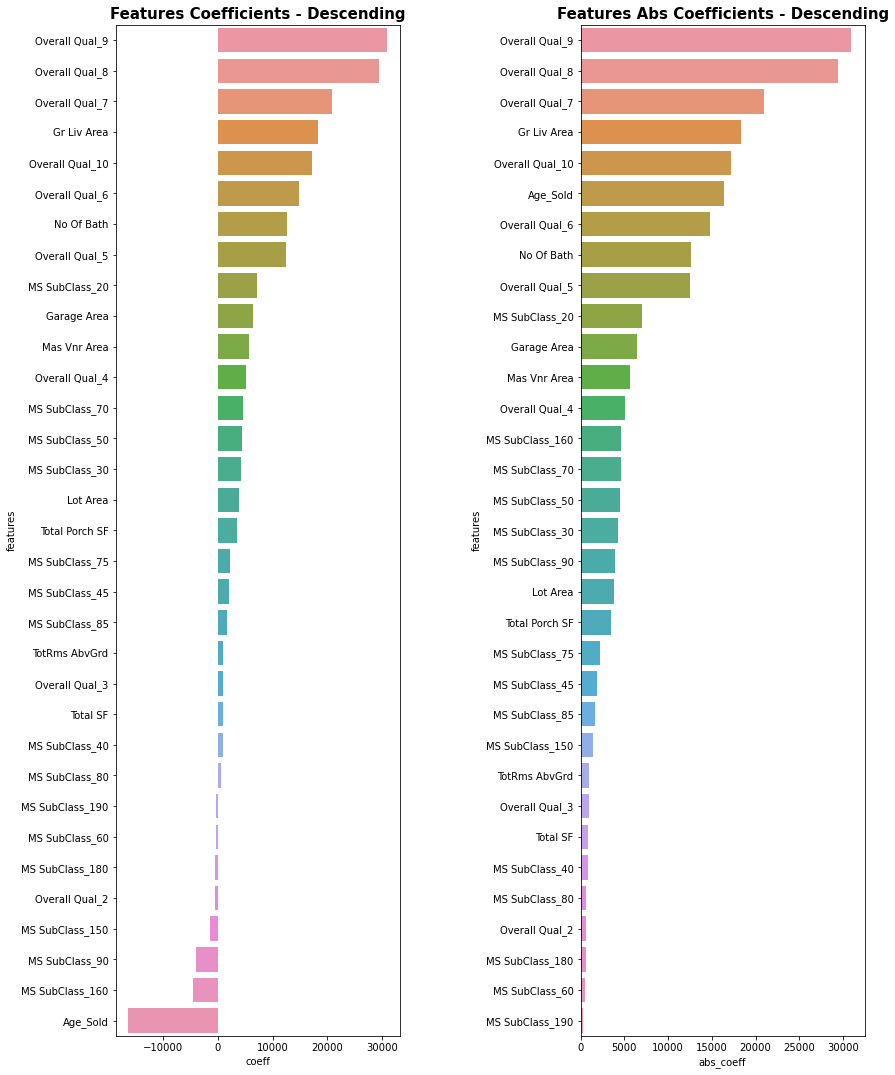

In [452]:
lr = ols_model_result(X_train_scaled, y_train, X_val_scaled, y_val)

Best alpha is 87.08431497690724

Using R2:-
Train R2 Score (Ridge):  0.8381249867308007
Train R2 Score (Ridge with CV):  0.8120881508281326
Validation R2 Score:  0.8782596713296099

Using RMSE:-
Train RMSE Score (Ridge):  31999.538142936413
Train RMSE Score (Ridge with CV):  33882.31670669224
Validation RMSE Score (Ridge):  27296.628680296988


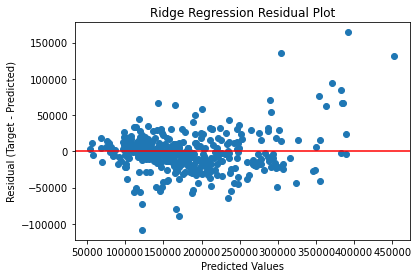

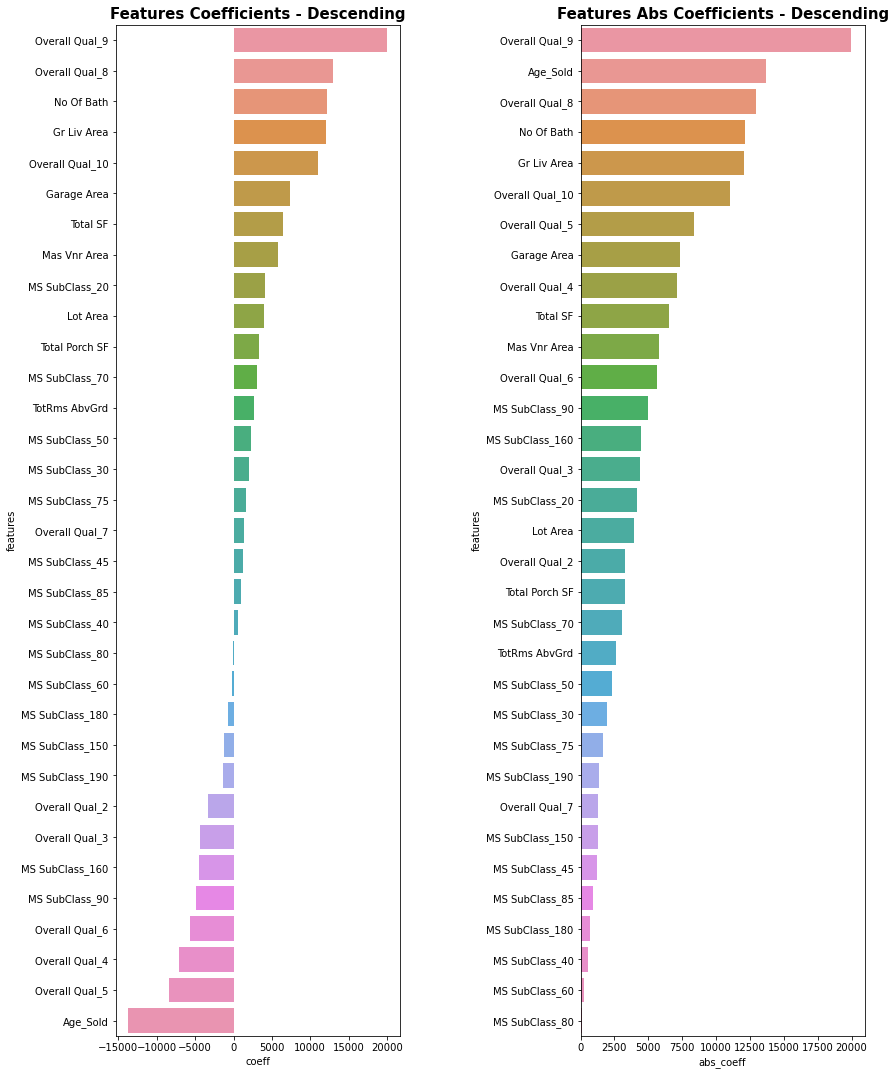

In [453]:
ridge_model = ridge_model_result(X_train_scaled, y_train, X_val_scaled, y_val, cv=5)

Best alpha is 172.6780903884356

Using R2:-
Train R2 Score (Lasso):  0.8393901104930234
Train R2 Score (Lasso with CV):  0.8116060099242084
Validation R2 Score:  0.880481126051117

Using RMSE:-
Train RMSE Score (Lasso):  31874.24769604936
Train RMSE Score (Lasso with CV):  33923.731952856106
Validation RMSE Score (Lasso):  27046.43467273207


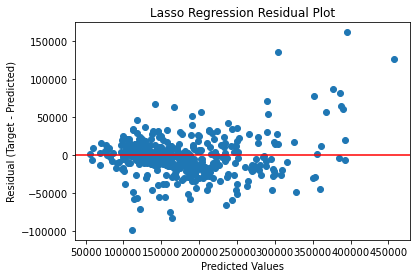

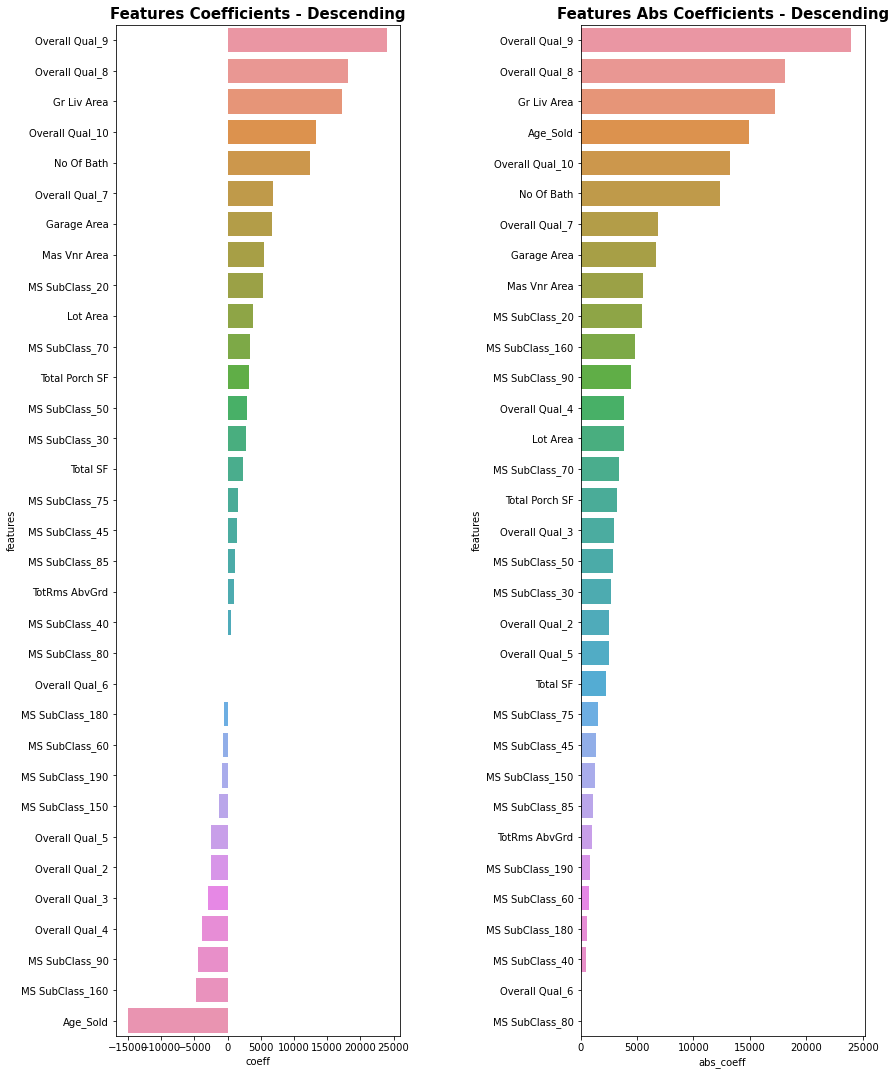

In [454]:
lasso_model = lasso_model_result(X_train_scaled, y_train, X_val_scaled, y_val, cv=5)

#### Finalized Features

In [455]:
# Final Selected Features
model_features_list = []
drop_features = ['Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Open Porch SF', 'Enclosed Porch', 
                 '3Ssn Porch', 'Screen Porch', 'Full Bath', 'MS Zoning', 
                 'Condition 2', 'House Style', 'Exterior 2nd', 'Exter Qual',
                 'Central Air', 'Electrical', 'Garage Type', 'Fireplace Qu', 'Amenities SF']

for feature in usable_model_features_list:
    if feature not in drop_features:
        model_features_list.append(feature)

In [456]:
X_train_scaled, X_val_scaled, y_train, y_val = pre_model_prep(data, model_features_list, train_size=0.8, random_state=60)

Using R2:-
Train R2 Score (OLS):  0.8910700576980735
Train R2 Score (OLS with CV):  -1.136841906526251e+23
Validation R2 Score:  -7.300655837718138e+16

Using RMSE:-
Train RMSE Score (OLS):  26249.887010237217
Train RMSE Score (OLS with CV):  1.159742127305624e+16
Validation RMSE Score (OLS):  21138429358238.992


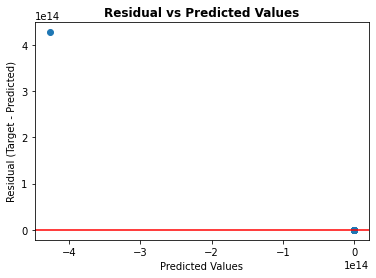

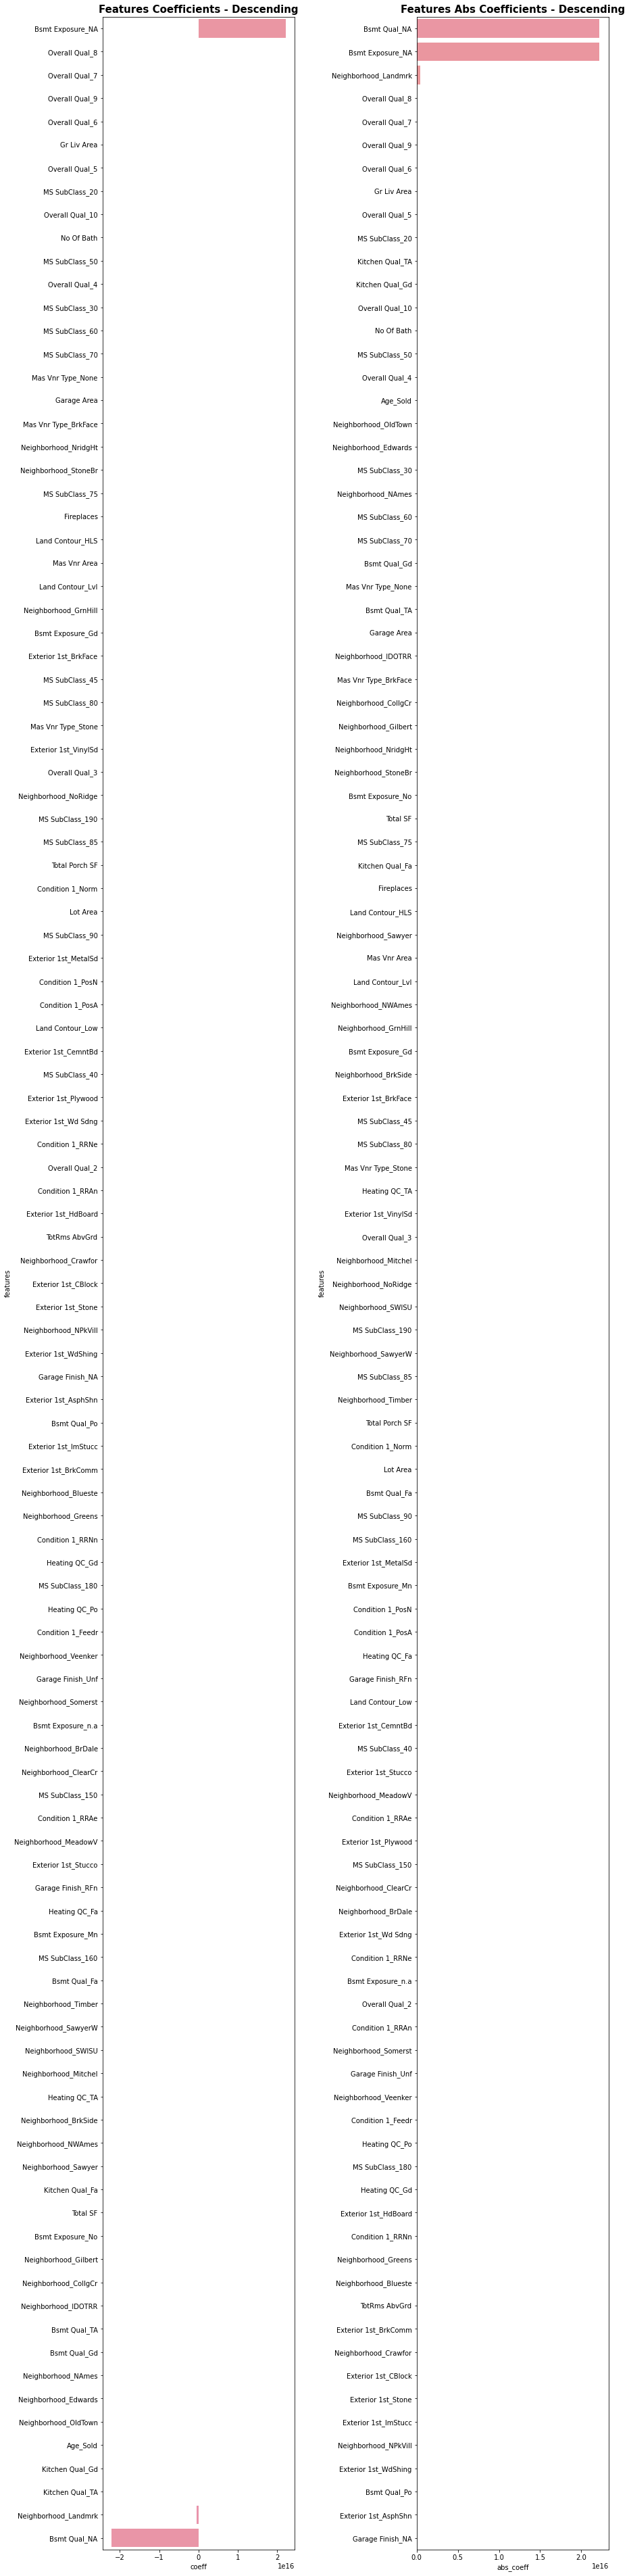

In [457]:
lr = ols_model_result(X_train_scaled, y_train, X_val_scaled, y_val)

Best alpha is 14.831025143361044

Using R2:-
Train R2 Score (Ridge):  0.8903024978128276
Train R2 Score (Ridge with CV):  0.8552130228889604
Validation R2 Score:  0.9049097790242507

Using RMSE:-
Train RMSE Score (Ridge):  26342.207777022824
Train RMSE Score (Ridge with CV):  29784.875915581604
Validation RMSE Score (Ridge):  24124.576900957854


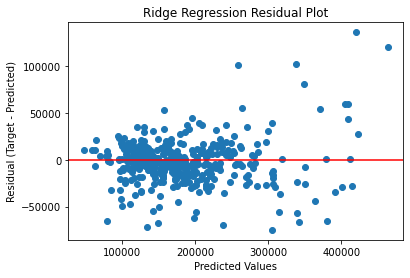

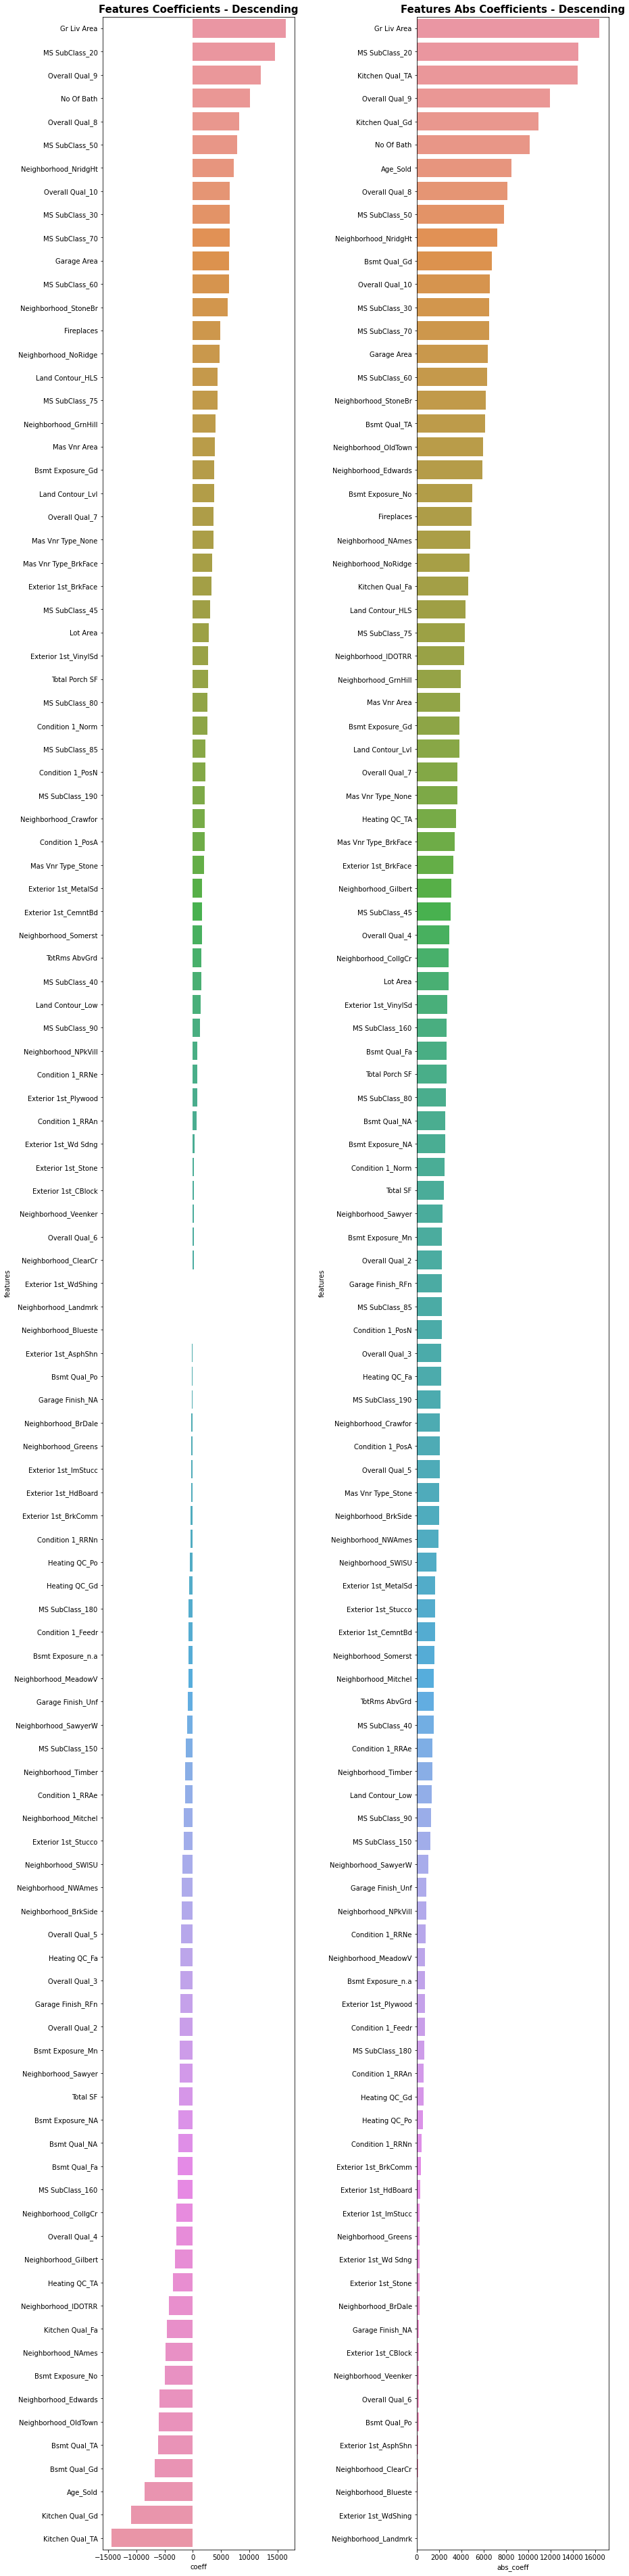

In [458]:
ridge_model = ridge_model_result(X_train_scaled, y_train, X_val_scaled, y_val, cv=5)

Best alpha is 15.352750287804211

Using R2:-
Train R2 Score (Lasso):  0.8908543891876421
Train R2 Score (Lasso with CV):  0.8550182273179219
Validation R2 Score:  0.9051428550900584

Using RMSE:-
Train RMSE Score (Lasso):  26275.860009565076
Train RMSE Score (Lasso with CV):  29828.029347398602
Validation RMSE Score (Lasso):  24094.992832270087


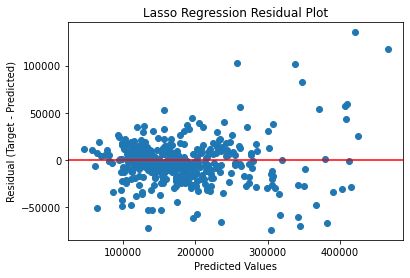

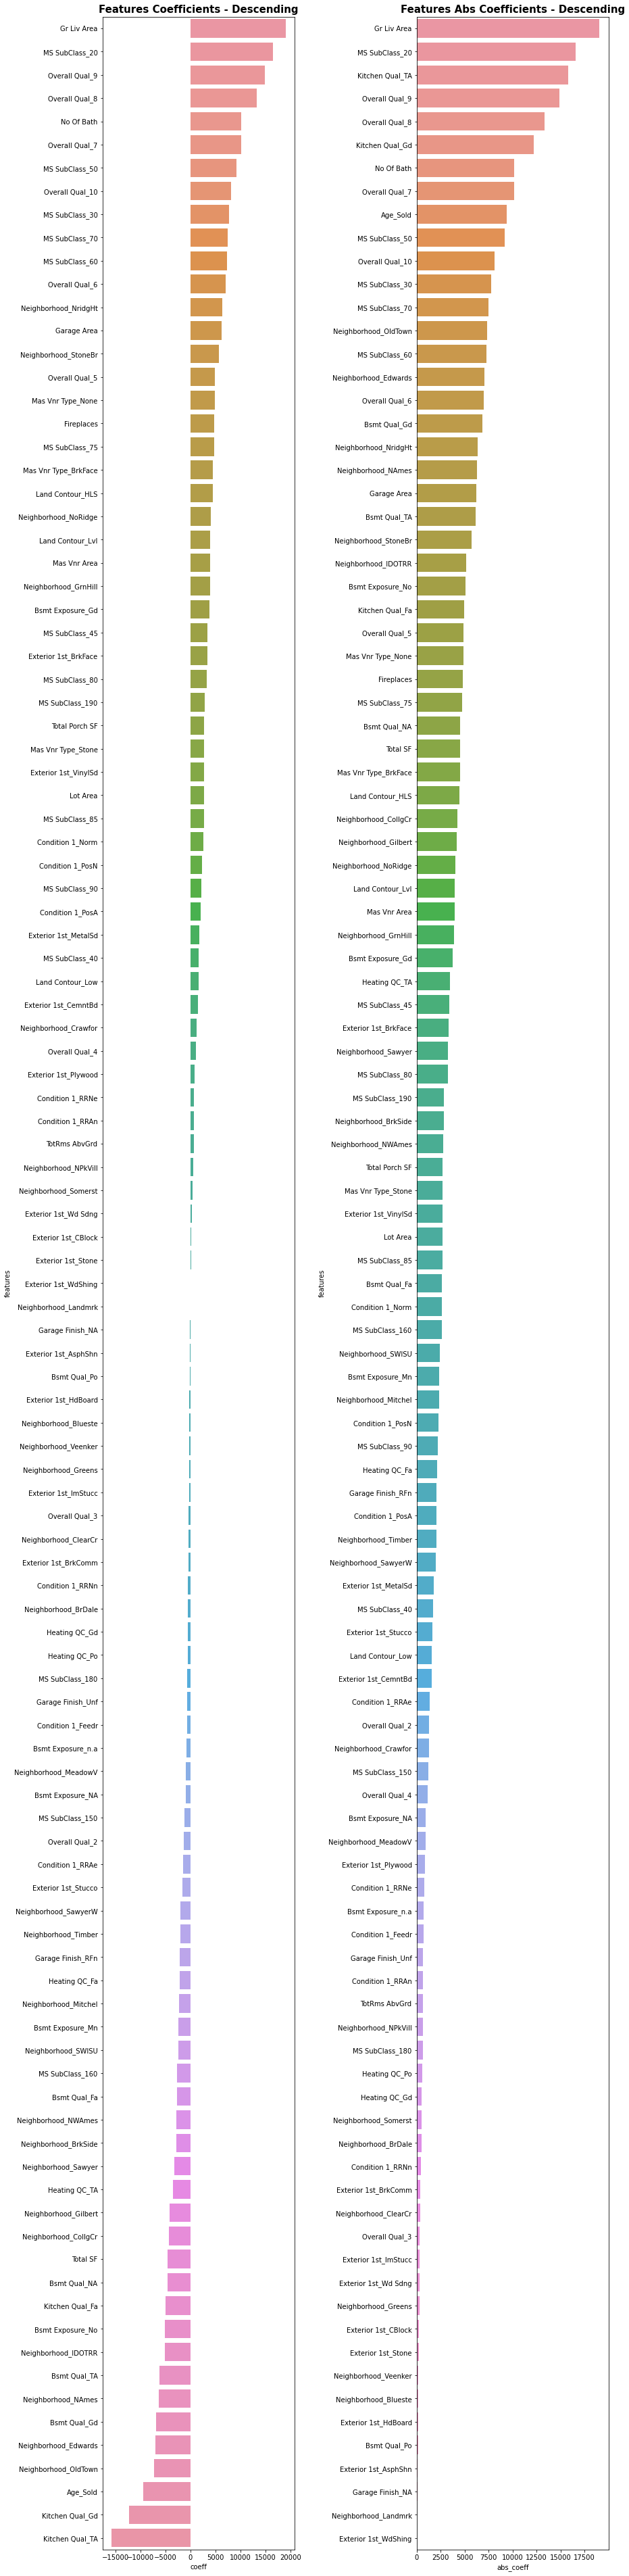

In [459]:
lasso_model = lasso_model_result(X_train_scaled, y_train, X_val_scaled, y_val, cv=5)

After testing all features in the usable_model_features_list, the 22 features selected are:-

|Features|Description|
|:---|---:|
|Age_Sold|Age of House when sold|
|Total SF|Total square feet of basement, 1st floor and 2nd floor|
|Lot Area|Size of Lot|
|Mas Vnr Area|Area of Masonry veneer|
|Gr Live Area|Above grade (ground) living area|
|Overall Qual|Overall material and finish of the house|
|No Of Bath|Number of full bath and half bath. Half bath is considered 0.5 bath of full bath|
|TotRms AbvGrd|Total rooms above grade (does not include bathrooms)|
|Garage Area|Size of Garage|
|Fireplaces|Number of fireplaces|
|Total Porch SF|Size of porch (Open/Enclosed/Three season/Screen)|
|MS SubClass|Identifies the type of dwelling involved in the sale|
|Land Contour|Flatness of the property|
|Neighborhood|Physical locations within Ames city limits|
|Condition 1|Proximity to various conditions|
|Exterior 1st|Exterior covering on house|
|Mas Vnr Type|Masonry veneer type|
|Bsmt Qual|Evaluates the height of the basement|
|Bsmt Exposure|Refers to walkout or garden level walls|
|Heating QC|Heating quality and condition|
|Kitchen Qual|Kitchen quality|
|Garage Finish|Interior finish of the garage|

As the OLS model using the finalized set of features shows very high error as it was overfitting to a few specific features, the score for it is not shown below.

||Ridge R2|Lasso R2|Ridge RMSE|Lasso RMSE|
|:---:|:---:|:---:|:---:|:---:|
|Train|0.8940|0.8940|26231.5331|26225.0161|
|CV|0.8590|0.8594|29799.9260|29755.5313|
|Validation|0.8932|0.8933|23825.1331| 23818.0141|

However, looking at the RMSE score of CV, it is often much higher than the train and validation score. This might meant that perhaps the model is not fitting well for some of the data.

#### Checking residual plot of CV

<AxesSubplot:xlabel='Y_predict', ylabel='y_residual'>

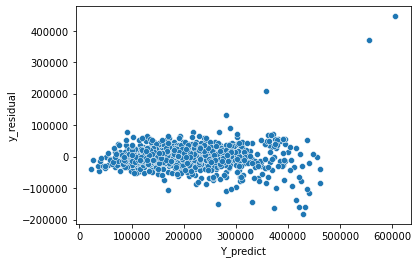

In [460]:
# Residual Plot showing points where model is not fitting well
y_df = pd.DataFrame(y_train).copy()
cv_y = cross_val_predict(ridge_model, X_train_scaled, y_train, cv=5)
y_df['Y_predict'] = cross_val_predict(ridge_model, X_train_scaled, y_train, cv=5)
y_df['y_residual'] = y_df['Y_predict'] - y_df['SalePrice']
sns.scatterplot(x= y_df['Y_predict'], y = y_df['y_residual'])

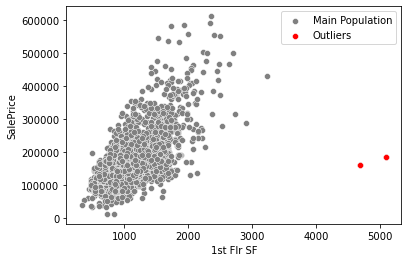

In [461]:
# Showing outlier coming from 1st Flr SF
outlier_index = list(y_df[y_df['y_residual'] > 300000].index)
sns.scatterplot(x='1st Flr SF', y ='SalePrice', data=data, color='grey', label='Main Population')
sns.scatterplot(x='1st Flr SF', y ='SalePrice', data=data.loc[outlier_index,['SalePrice', 'Lot Area', '1st Flr SF']], color = 'red', label='Outliers')
plt.legend()

As it is very rare for houses with large 1st floor area selling at a low price, there might some critical information that would explain the low price missing from the data collected. Since our model is unable generalize to those 2 outliers and majority of the data is from 1st Flr SF less than 4500, the model will be restricted to modeling 1st Flr SF of 4500 or smaller.

As OLS regression tends to overfit resulting in bad CV and validation score and lasso regression tends to require higher amount of iterations to converge despite showing similar score as ridge regression, ridge regression will be used for the final production model as very few features (after one hot encoding) had coefficients values of 0.

#### Final Model

In [462]:
# Performance of model after filtering the 2 outliers
model_features_list = []
drop_features = ['Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Open Porch SF', 'Enclosed Porch', 
                 '3Ssn Porch', 'Screen Porch', 'Full Bath', 'MS Zoning', 
                 'Condition 2', 'House Style', 'Exterior 2nd', 'Exter Qual',
                 'Central Air', 'Electrical', 'Garage Type', 'Fireplace Qu', 'Amenities SF']

for feature in usable_model_features_list:
    if feature not in drop_features:
        model_features_list.append(feature)
        
X_train_scaled, X_val_scaled, y_train, y_val = pre_model_prep(data[data['1st Flr SF'] < 4500], model_features_list, train_size=0.8, random_state=60)

Best alpha is 26.633327251749822

Using R2:-
Train R2 Score (Ridge):  0.9250009661810867
Train R2 Score (Ridge with CV):  0.909578507849584
Validation R2 Score:  0.9122588951504031

Using RMSE:-
Train RMSE Score (Ridge):  21658.153369600164
Train RMSE Score (Ridge with CV):  23677.13043669645
Validation RMSE Score (Ridge):  23768.87336768371


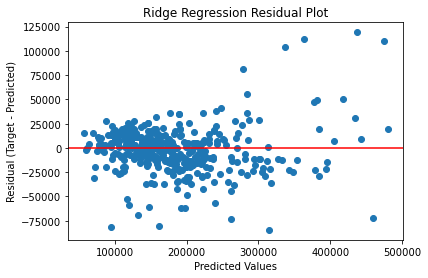

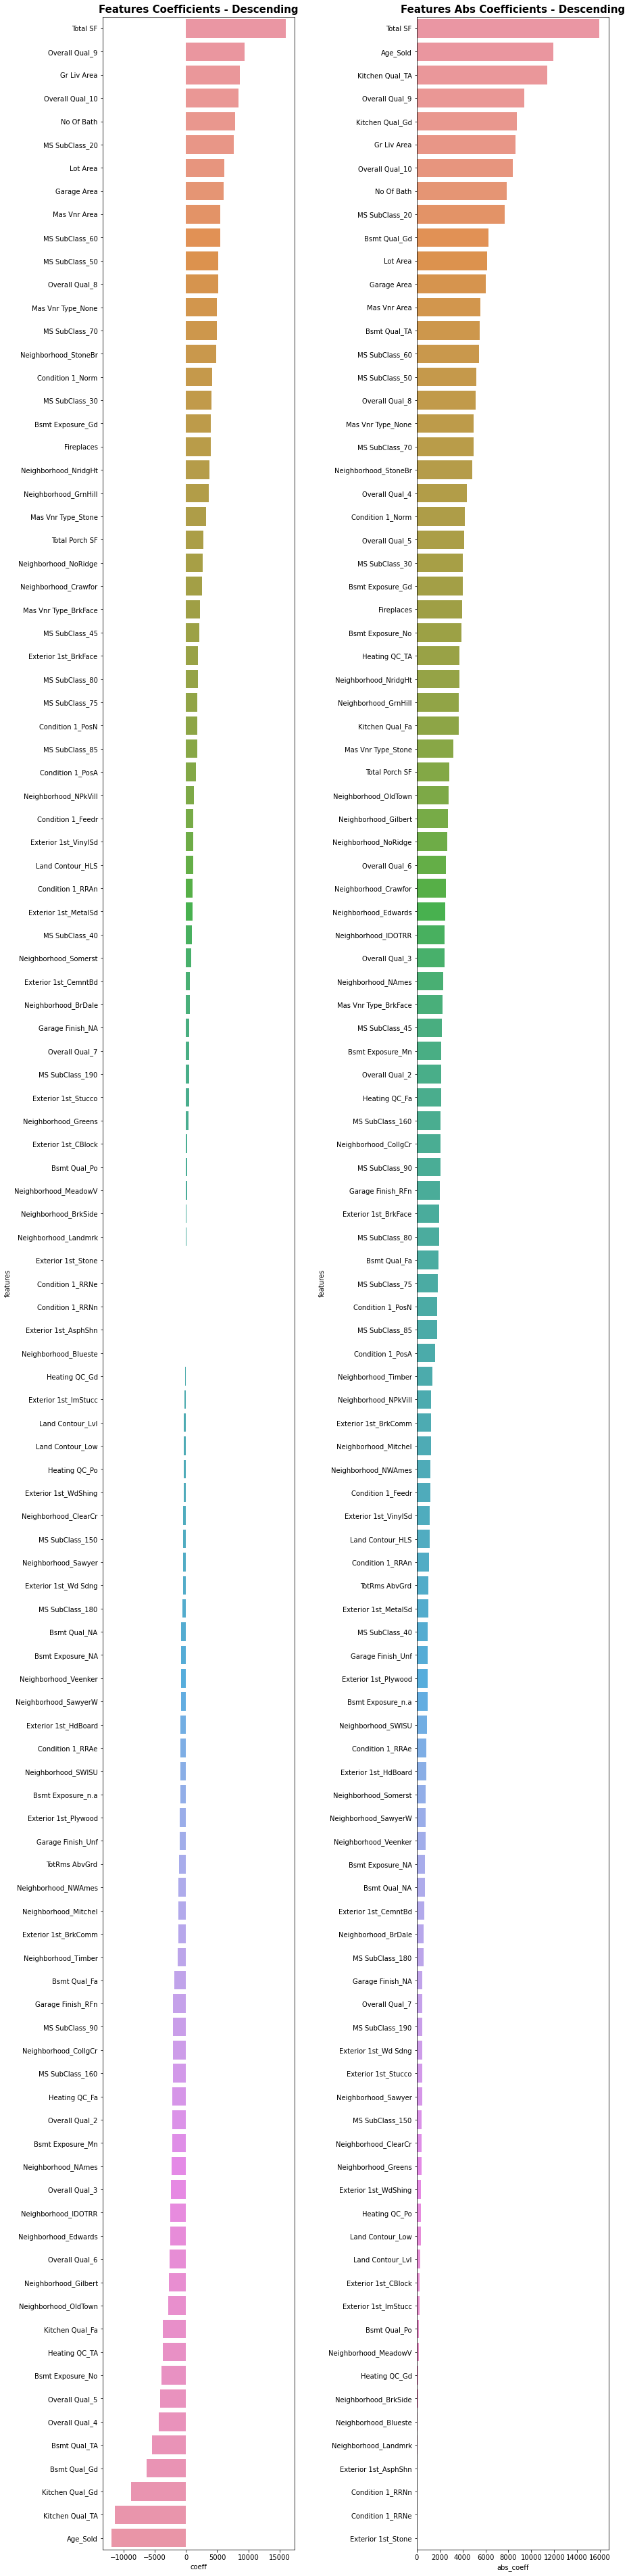

In [463]:
ridge_model = ridge_model_result(X_train_scaled, y_train, X_val_scaled, y_val, cv=5)

Text(0.5, 1.0, 'Top 20 Features Abs Coefficients - Descending')

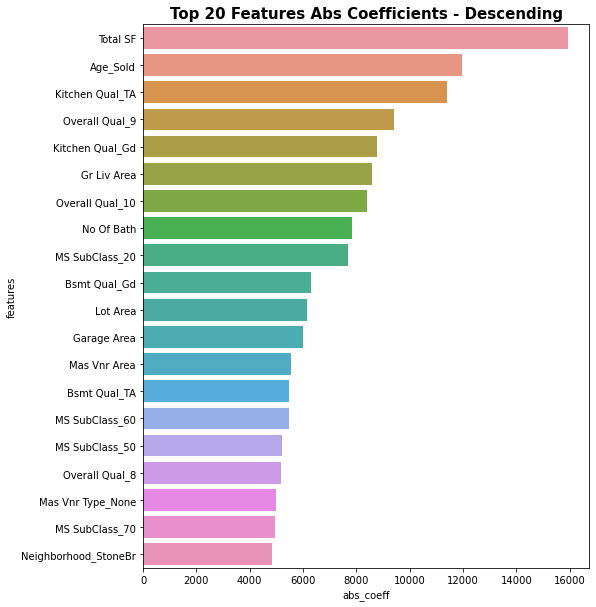

In [464]:
# Top 5 Most Influencing Features
plt.figure(figsize=(8,10))
coefficients_df = pd.DataFrame(zip(X_train_scaled.columns, ridge_model.coef_), columns=['features', 'coeff'])
coefficients_df.sort_values(by='coeff', ascending=False, inplace=True)
coefficients_df['abs_coeff'] = np.abs(coefficients_df['coeff'])
coefficients_df.sort_values(by='abs_coeff', ascending=False, inplace=True)
sns.barplot(x=coefficients_df.head(20)['abs_coeff'], y=coefficients_df.head(20)['features'])
plt.title('Top 20 Features Abs Coefficients - Descending', fontweight='bold', fontsize=15)

### Conclusions
In general, when selecting features for training the model, numerical features should have high absolute correlation score with the SalePrice with as little outliers as possible, while categorical features should have significantly different mean or median. These criteria are to allow the linear model better predict the SalePrice.


### Business Recommendations

Apart from the usual factor such as total floor area and age of the house, a buyer has to take note of the build quality (material and finish) of the house as well. By getting a house with overall quality rated 5 and above will cause the SalePrice to increase by at least USD 12,500. Lastly, the buyer should take note of the quality of the kitchen. Any kitchen that is below excellent would cause the price to decrease by a few thousands dollars. 

Should the buyer managed to find a house that costs lower than what the model predicted, he/she should consider buying it either for investment/rental or for living in. On the other hand, if the house costs more than what the model predicted, the SalePrice should be negotiated.